In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.local_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Preprocessing
## Audio Data

In [2]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

In [3]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

In [4]:
with tf.device('/GPU:0'):
    audio['data'] = audio.filepath.apply(preprocess_audio)
    audio = audio.sample(frac=1).reset_index(drop=True)

In [5]:
x_audio = np.stack(audio['data'].values)
y_audio = audio['label_encoded'].values
print(x_audio.shape)
del audio

In [6]:
x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
    x_audio, y_audio, test_size=0.3, random_state=100,
)

x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=222,
)

del x_audio, y_audio
print(x_audio_train.shape)
print(x_audio_train.shape[0] == len(y_audio_train))

# Modeling
## Model Image

In [12]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(100, 100, 3)),
)

In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [14]:
plot_model(model, show_shapes=True)

In [15]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [16]:
history = model.fit(
    x_audio_train,
    y_audio_train,
    validation_data=(x_audio_val, y_audio_val),
    # callbacks=[early, checkpoint, lr_scheduler],
    epochs=100,
    verbose=2,
    batch_size=128,
    steps_per_epoch=len(x_audio_train) // 128,
    validation_steps=len(x_audio_val) // 128,
)


Epoch 1/100
181/181 - 28s - loss: 1.7409 - accuracy: 0.3073 - val_loss: 1.5480 - val_accuracy: 0.4093 - 28s/epoch - 156ms/step
Epoch 2/100
181/181 - 20s - loss: 1.2731 - accuracy: 0.5170 - val_loss: 1.2636 - val_accuracy: 0.5170 - 20s/epoch - 113ms/step
Epoch 3/100
181/181 - 20s - loss: 0.9079 - accuracy: 0.6662 - val_loss: 1.2722 - val_accuracy: 0.5319 - 20s/epoch - 108ms/step
Epoch 4/100
181/181 - 19s - loss: 0.5809 - accuracy: 0.7973 - val_loss: 1.4549 - val_accuracy: 0.5416 - 19s/epoch - 107ms/step
Epoch 5/100
181/181 - 19s - loss: 0.3512 - accuracy: 0.8811 - val_loss: 1.5776 - val_accuracy: 0.5450 - 19s/epoch - 107ms/step
Epoch 6/100
181/181 - 19s - loss: 0.2312 - accuracy: 0.9220 - val_loss: 1.7728 - val_accuracy: 0.5543 - 19s/epoch - 107ms/step
Epoch 7/100
181/181 - 19s - loss: 0.1810 - accuracy: 0.9387 - val_loss: 1.8882 - val_accuracy: 0.5430 - 19s/epoch - 107ms/step
Epoch 8/100
181/181 - 19s - loss: 0.1537 - accuracy: 0.9488 - val_loss: 2.0100 - val_accuracy: 0.5577 - 19s/epo

# Evaluate Model
## Using the model.evaluate
### using test set

In [17]:
print(model.evaluate(x_audio_test, y_audio_test, batch_size=BATCH_SIZE, steps=len(x_audio_test) // BATCH_SIZE))

228/228 [==============================] - 3s 11ms/step - loss: 2.9297 - accuracy: 0.5698
[2.9297237396240234, 0.569764256477356]


### Using validation set

In [18]:
print(model.evaluate(x_audio_val, y_audio_val, batch_size=BATCH_SIZE, steps=len(x_audio_val) // BATCH_SIZE))

311/311 [==============================] - 3s 10ms/step - loss: 2.5516 - accuracy: 0.6125
[2.5515756607055664, 0.6125401854515076]


In [19]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [20]:
plot_and_save('loss', history, 'Loss', 'loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

In [21]:
predictions = model.predict(x_audio_test)
predictions = np.argmax(predictions, axis=1)

229/229 [==============================] - 3s 10ms/step


In [22]:
classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


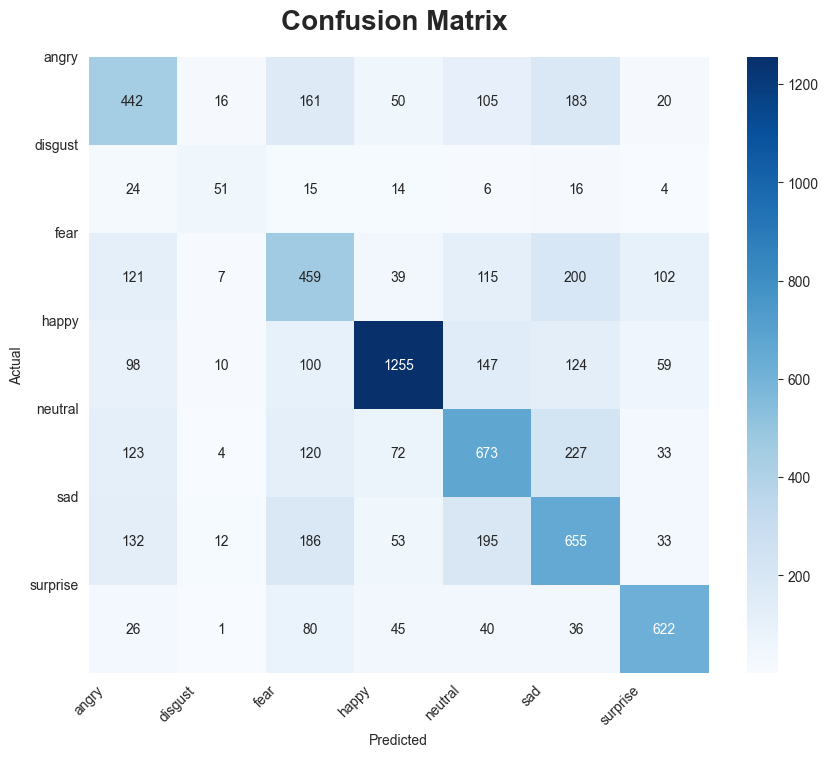

In [23]:
cm = confusion_matrix(y_audio_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix ', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(predictions, y_audio_test))